In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_0_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(369744, 828)
(369744, 1)
validation
(50536, 828)
(50536, 1)
test
(51136, 828)
(51136, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/37 [..............................] - ETA: 42s - loss: 0.0225 - STD: 1.2215e-04 - MAE: 0.1402

 4/37 [==>...........................] - ETA: 1s - loss: 0.0218 - STD: 2.3220e-04 - MAE: 0.1140 

 5/37 [===>..........................] - ETA: 1s - loss: 0.0205 - STD: 2.5150e-04 - MAE: 0.1055

 6/37 [===>..........................] - ETA: 1s - loss: 0.0188 - STD: 2.8970e-04 - MAE: 0.0980

 7/37 [====>.........................] - ETA: 1s - loss: 0.0180 - STD: 3.3886e-04 - MAE: 0.0975

 8/37 [=====>........................] - ETA: 1s - loss: 0.0178 - STD: 3.9250e-04 - MAE: 0.0998

 9/37 [======>.......................] - ETA: 1s - loss: 0.0175 - STD: 4.4478e-04 - MAE: 0.1007

10/37 [=======>......................] - ETA: 1s - loss: 0.0169 - STD: 4.9009e-04 - MAE: 0.0992

11/37 [=======>......................] - ETA: 1s - loss: 0.0163 - STD: 5.2705e-04 - MAE: 0.0959

12/37 [========>.....................] - ETA: 1s - loss: 0.0159 - STD: 5.5782e-04 - MAE: 0.0926

13/37 [=========>....................] - ETA: 1s - loss: 0.0157 - STD: 5.8378e-04 - MAE: 0.0900

14/37 [==========>...................] - ETA: 1s - loss: 0.0155 - STD: 6.0883e-04 - MAE: 0.0880

15/37 [===========>..................] - ETA: 1s - loss: 0.0153 - STD: 6.3504e-04 - MAE: 0.0861

16/37 [===========>..................] - ETA: 1s - loss: 0.0151 - STD: 6.6353e-04 - MAE: 0.0842

17/37 [============>.................] - ETA: 1s - loss: 0.0148 - STD: 6.9704e-04 - MAE: 0.0826

18/37 [=============>................] - ETA: 1s - loss: 0.0146 - STD: 7.3390e-04 - MAE: 0.0815

19/37 [==============>...............] - ETA: 0s - loss: 0.0144 - STD: 7.7411e-04 - MAE: 0.0811

20/37 [===============>..............] - ETA: 0s - loss: 0.0142 - STD: 8.1565e-04 - MAE: 0.0812

21/37 [================>.............] - ETA: 1s - loss: 0.0141 - STD: 8.5764e-04 - MAE: 0.0814

25/37 [===================>..........] - ETA: 0s - loss: 0.0136 - STD: 0.0010 - MAE: 0.0797    

26/37 [====================>.........] - ETA: 0s - loss: 0.0135 - STD: 0.0010 - MAE: 0.0788

27/37 [====================>.........] - ETA: 0s - loss: 0.0134 - STD: 0.0011 - MAE: 0.0778

28/37 [=====================>........] - ETA: 0s - loss: 0.0133 - STD: 0.0011 - MAE: 0.0771

29/37 [======================>.......] - ETA: 0s - loss: 0.0132 - STD: 0.0012 - MAE: 0.0763

30/37 [=======================>......] - ETA: 0s - loss: 0.0131 - STD: 0.0012 - MAE: 0.0757

31/37 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0012 - MAE: 0.0752

32/37 [========================>.....] - ETA: 0s - loss: 0.0130 - STD: 0.0013 - MAE: 0.0750

33/37 [=========================>....] - ETA: 0s - loss: 0.0129 - STD: 0.0014 - MAE: 0.0749

34/37 [==========================>...] - ETA: 0s - loss: 0.0128 - STD: 0.0014 - MAE: 0.0748

35/37 [===========================>..] - ETA: 0s - loss: 0.0128 - STD: 0.0015 - MAE: 0.0748

36/37 [============================>.] - ETA: 0s - loss: 0.0127 - STD: 0.0015 - MAE: 0.0747

37/37 [==============================] - ETA: 0s - loss: 0.0126 - STD: 0.0016 - MAE: 0.0744

37/37 [==============================] - 4s 86ms/step - loss: 0.0126 - STD: 0.0016 - MAE: 0.0744 - val_loss: 0.0142 - val_STD: 0.0037 - val_MAE: 0.0663


Epoch 2/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0105 - STD: 0.0043 - MAE: 0.0631

 2/37 [>.............................] - ETA: 2s - loss: 0.0103 - STD: 0.0044 - MAE: 0.0611

 3/37 [=>............................] - ETA: 2s - loss: 0.0103 - STD: 0.0045 - MAE: 0.0598

 4/37 [==>...........................] - ETA: 1s - loss: 0.0103 - STD: 0.0047 - MAE: 0.0591

 5/37 [===>..........................] - ETA: 1s - loss: 0.0103 - STD: 0.0048 - MAE: 0.0588

 6/37 [===>..........................] - ETA: 1s - loss: 0.0101 - STD: 0.0050 - MAE: 0.0585

 7/37 [====>.........................] - ETA: 1s - loss: 0.0101 - STD: 0.0053 - MAE: 0.0587

 8/37 [=====>........................] - ETA: 1s - loss: 0.0100 - STD: 0.0055 - MAE: 0.0591

 9/37 [======>.......................] - ETA: 1s - loss: 0.0100 - STD: 0.0058 - MAE: 0.0597

10/37 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 0.0062 - MAE: 0.0602

11/37 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 0.0065 - MAE: 0.0606

12/37 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 0.0068 - MAE: 0.0607

13/37 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 0.0072 - MAE: 0.0607

14/37 [==========>...................] - ETA: 1s - loss: 0.0098 - STD: 0.0076 - MAE: 0.0605

15/37 [===========>..................] - ETA: 1s - loss: 0.0098 - STD: 0.0080 - MAE: 0.0602

16/37 [===========>..................] - ETA: 1s - loss: 0.0097 - STD: 0.0084 - MAE: 0.0599

17/37 [============>.................] - ETA: 1s - loss: 0.0097 - STD: 0.0089 - MAE: 0.0598

18/37 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0094 - MAE: 0.0596

19/37 [==============>...............] - ETA: 1s - loss: 0.0096 - STD: 0.0100 - MAE: 0.0596

20/37 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 0.0107 - MAE: 0.0595

21/37 [================>.............] - ETA: 0s - loss: 0.0095 - STD: 0.0114 - MAE: 0.0594

22/37 [================>.............] - ETA: 0s - loss: 0.0094 - STD: 0.0122 - MAE: 0.0591

23/37 [=================>............] - ETA: 0s - loss: 0.0093 - STD: 0.0130 - MAE: 0.0588

24/37 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 0.0138 - MAE: 0.0585

25/37 [===================>..........] - ETA: 0s - loss: 0.0091 - STD: 0.0147 - MAE: 0.0581

26/37 [====================>.........] - ETA: 0s - loss: 0.0090 - STD: 0.0158 - MAE: 0.0578

27/37 [====================>.........] - ETA: 0s - loss: 0.0089 - STD: 0.0169 - MAE: 0.0575

28/37 [=====================>........] - ETA: 0s - loss: 0.0088 - STD: 0.0180 - MAE: 0.0573

29/37 [======================>.......] - ETA: 0s - loss: 0.0087 - STD: 0.0192 - MAE: 0.0570

30/37 [=======================>......] - ETA: 0s - loss: 0.0086 - STD: 0.0205 - MAE: 0.0567

32/37 [========================>.....] - ETA: 0s - loss: 0.0084 - STD: 0.0230 - MAE: 0.0561

33/37 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0243 - MAE: 0.0558

34/37 [==========================>...] - ETA: 0s - loss: 0.0083 - STD: 0.0256 - MAE: 0.0556

35/37 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0269 - MAE: 0.0553

36/37 [============================>.] - ETA: 0s - loss: 0.0081 - STD: 0.0281 - MAE: 0.0550

37/37 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.0293 - MAE: 0.0547

37/37 [==============================] - 2s 63ms/step - loss: 0.0080 - STD: 0.0293 - MAE: 0.0547 - val_loss: 0.0046 - val_STD: 0.0615 - val_MAE: 0.0394


Epoch 3/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0421

 2/37 [>.............................] - ETA: 2s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0418

 3/37 [=>............................] - ETA: 2s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0420

 4/37 [==>...........................] - ETA: 2s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0417

 5/37 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0740 - MAE: 0.0412

 6/37 [===>..........................] - ETA: 2s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0407

 7/37 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0403

 8/37 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0749 - MAE: 0.0401

 9/37 [======>.......................] - ETA: 1s - loss: 0.0038 - STD: 0.0759 - MAE: 0.0398

10/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0768 - MAE: 0.0396

11/37 [=======>......................] - ETA: 1s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0394

12/37 [========>.....................] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0392

13/37 [=========>....................] - ETA: 1s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0391

14/37 [==========>...................] - ETA: 1s - loss: 0.0036 - STD: 0.0796 - MAE: 0.0390

15/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0388

16/37 [===========>..................] - ETA: 1s - loss: 0.0036 - STD: 0.0808 - MAE: 0.0387

17/37 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0385

18/37 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0810 - MAE: 0.0383

19/37 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0812 - MAE: 0.0382

20/37 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0817 - MAE: 0.0381

21/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0820 - MAE: 0.0380

22/37 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0820 - MAE: 0.0379

23/37 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0822 - MAE: 0.0378

24/37 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0826 - MAE: 0.0377

25/37 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0830 - MAE: 0.0376

26/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0833 - MAE: 0.0375

27/37 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0833 - MAE: 0.0374

28/37 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0834 - MAE: 0.0373

29/37 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0836 - MAE: 0.0372

30/37 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0839 - MAE: 0.0371

31/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0842 - MAE: 0.0371

32/37 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0843 - MAE: 0.0370

33/37 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0843 - MAE: 0.0369

34/37 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0843 - MAE: 0.0368

35/37 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0845 - MAE: 0.0368

36/37 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0847 - MAE: 0.0367

37/37 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0848 - MAE: 0.0367

37/37 [==============================] - 3s 71ms/step - loss: 0.0033 - STD: 0.0848 - MAE: 0.0367 - val_loss: 0.0028 - val_STD: 0.0766 - val_MAE: 0.0313


Epoch 4/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.0862 - MAE: 0.0338

 2/37 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0873 - MAE: 0.0338

 3/37 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0890 - MAE: 0.0341

 4/37 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0892 - MAE: 0.0342

 5/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0891 - MAE: 0.0343

 6/37 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0888 - MAE: 0.0342

 7/37 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0888 - MAE: 0.0342

 8/37 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0892 - MAE: 0.0342

 9/37 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0890 - MAE: 0.0342

10/37 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0888 - MAE: 0.0342

11/37 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0886 - MAE: 0.0341

12/37 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0888 - MAE: 0.0342

13/37 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0889 - MAE: 0.0342

14/37 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0887 - MAE: 0.0341

15/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0885 - MAE: 0.0341

16/37 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0885 - MAE: 0.0341

17/37 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0888 - MAE: 0.0341

18/37 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0341

19/37 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0887 - MAE: 0.0341

20/37 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0340

21/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0340

22/37 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0340

23/37 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0884 - MAE: 0.0340

24/37 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0340

25/37 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0883 - MAE: 0.0340

26/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0340

27/37 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0340

28/37 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0339

29/37 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0885 - MAE: 0.0339

30/37 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0887 - MAE: 0.0339

31/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0339

32/37 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0339

33/37 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0887 - MAE: 0.0338

34/37 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0338

35/37 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0338

36/37 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0338

37/37 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0888 - MAE: 0.0337

37/37 [==============================] - 3s 72ms/step - loss: 0.0027 - STD: 0.0888 - MAE: 0.0337 - val_loss: 0.0028 - val_STD: 0.0775 - val_MAE: 0.0309


Epoch 5/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.0872 - MAE: 0.0327

 2/37 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0893 - MAE: 0.0330

 3/37 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0893 - MAE: 0.0330

 4/37 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0892 - MAE: 0.0330

 5/37 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0885 - MAE: 0.0330

 6/37 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.0889 - MAE: 0.0330

 7/37 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0890 - MAE: 0.0329

 8/37 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0887 - MAE: 0.0329

 9/37 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0888 - MAE: 0.0329

10/37 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0893 - MAE: 0.0329

11/37 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0893 - MAE: 0.0329

12/37 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0328

13/37 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0894 - MAE: 0.0328

14/37 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0328

15/37 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0328

16/37 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0328

17/37 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0328

18/37 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0328

19/37 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0328

20/37 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0328

21/37 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0328

22/37 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0327

23/37 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0895 - MAE: 0.0327

24/37 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0327

25/37 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0327

26/37 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0327

27/37 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0327

28/37 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0327

29/37 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0327

30/37 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0327

31/37 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0327

32/37 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0896 - MAE: 0.0327

33/37 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0897 - MAE: 0.0327

34/37 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0326

35/37 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0326

36/37 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0898 - MAE: 0.0326

37/37 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.0899 - MAE: 0.0326

37/37 [==============================] - 2s 63ms/step - loss: 0.0025 - STD: 0.0899 - MAE: 0.0326 - val_loss: 0.0028 - val_STD: 0.0783 - val_MAE: 0.0303


Epoch 6/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.0913 - MAE: 0.0319

 2/37 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0896 - MAE: 0.0317

 3/37 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0899 - MAE: 0.0319

 4/37 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0901 - MAE: 0.0318

 5/37 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0897 - MAE: 0.0318

 6/37 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0318

 7/37 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0900 - MAE: 0.0317

 8/37 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0900 - MAE: 0.0316

 9/37 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0899 - MAE: 0.0316

10/37 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

11/37 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0316

12/37 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0317

13/37 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0901 - MAE: 0.0317

14/37 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0317

15/37 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0317

16/37 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0317

17/37 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0904 - MAE: 0.0317

18/37 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0317

19/37 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0316

20/37 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

21/37 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0316

22/37 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.0901 - MAE: 0.0316

23/37 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0901 - MAE: 0.0315

24/37 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0316

25/37 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0316

26/37 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0315

27/37 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

28/37 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0901 - MAE: 0.0316

29/37 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0315

30/37 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

31/37 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0316

32/37 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0902 - MAE: 0.0315

33/37 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0904 - MAE: 0.0316

34/37 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

35/37 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0315

36/37 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

37/37 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316

37/37 [==============================] - 3s 70ms/step - loss: 0.0024 - STD: 0.0903 - MAE: 0.0316 - val_loss: 0.0028 - val_STD: 0.0781 - val_MAE: 0.0296


Epoch 7/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0883 - MAE: 0.0301

 2/37 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0929 - MAE: 0.0313

 3/37 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0905 - MAE: 0.0308

 4/37 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0900 - MAE: 0.0311

 5/37 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0909 - MAE: 0.0315

 6/37 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0912 - MAE: 0.0314

 7/37 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0904 - MAE: 0.0314

 8/37 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0909 - MAE: 0.0315

 9/37 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0911 - MAE: 0.0314

10/37 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0907 - MAE: 0.0314

11/37 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0907 - MAE: 0.0313

12/37 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0911 - MAE: 0.0314

13/37 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0908 - MAE: 0.0313

14/37 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0907 - MAE: 0.0312

15/37 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0312

16/37 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0907 - MAE: 0.0312

17/37 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0906 - MAE: 0.0312

18/37 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0312

19/37 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0312

20/37 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0907 - MAE: 0.0311

21/37 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0312

22/37 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0312

23/37 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0311

24/37 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0311

25/37 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0310

26/37 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0310

27/37 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0309

28/37 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0309

29/37 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0308

30/37 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0308

31/37 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0308

32/37 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0307

33/37 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0307

34/37 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0307

35/37 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0909 - MAE: 0.0307

36/37 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0910 - MAE: 0.0307

37/37 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0908 - MAE: 0.0307

37/37 [==============================] - 3s 70ms/step - loss: 0.0023 - STD: 0.0908 - MAE: 0.0307 - val_loss: 0.0027 - val_STD: 0.0821 - val_MAE: 0.0298


Epoch 8/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0022 - STD: 0.0911 - MAE: 0.0303

 2/37 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0913 - MAE: 0.0301

 3/37 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0908 - MAE: 0.0301

 4/37 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0924 - MAE: 0.0303

 5/37 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0303

 6/37 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0301

 7/37 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0302

 8/37 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0909 - MAE: 0.0303

 9/37 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0911 - MAE: 0.0304

10/37 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0912 - MAE: 0.0304

11/37 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0906 - MAE: 0.0304

12/37 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0910 - MAE: 0.0305

13/37 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0910 - MAE: 0.0305

14/37 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0909 - MAE: 0.0304

15/37 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0912 - MAE: 0.0304

16/37 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0911 - MAE: 0.0303

17/37 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0911 - MAE: 0.0303

18/37 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0303

19/37 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0302

20/37 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0302

21/37 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0302

22/37 [================>.............] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0302

23/37 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0301

24/37 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0301

25/37 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

26/37 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0301

27/37 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0914 - MAE: 0.0301

28/37 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

29/37 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0301

30/37 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0301

31/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0300

32/37 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0300

33/37 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0300

34/37 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0300

35/37 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0300

36/37 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0300

37/37 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0299

37/37 [==============================] - 3s 71ms/step - loss: 0.0022 - STD: 0.0915 - MAE: 0.0299 - val_loss: 0.0026 - val_STD: 0.0832 - val_MAE: 0.0299


Epoch 9/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0918 - MAE: 0.0300

 2/37 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0921 - MAE: 0.0300

 3/37 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0924 - MAE: 0.0299

 4/37 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0916 - MAE: 0.0297

 5/37 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0296

 6/37 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0917 - MAE: 0.0296

 7/37 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0916 - MAE: 0.0296

 8/37 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0295

 9/37 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0295

10/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0296

11/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0913 - MAE: 0.0295

12/37 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0295

13/37 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0911 - MAE: 0.0296

14/37 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0915 - MAE: 0.0299

15/37 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0912 - MAE: 0.0301

16/37 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0915 - MAE: 0.0301

17/37 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0916 - MAE: 0.0300

18/37 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0300

19/37 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0916 - MAE: 0.0300

20/37 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0300

21/37 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0912 - MAE: 0.0299

22/37 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0299

23/37 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0914 - MAE: 0.0299

24/37 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0916 - MAE: 0.0299

25/37 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0918 - MAE: 0.0299

26/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0918 - MAE: 0.0299

27/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0299

28/37 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0299

29/37 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0917 - MAE: 0.0298

30/37 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0918 - MAE: 0.0299

31/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0918 - MAE: 0.0299

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0299

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0299

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0299

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0299

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0299

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0299

37/37 [==============================] - 2s 67ms/step - loss: 0.0021 - STD: 0.0919 - MAE: 0.0299 - val_loss: 0.0026 - val_STD: 0.0853 - val_MAE: 0.0311


Epoch 10/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0913 - MAE: 0.0302

 2/37 [>.............................] - ETA: 1s - loss: 0.0021 - STD: 0.0911 - MAE: 0.0295

 3/37 [=>............................] - ETA: 1s - loss: 0.0020 - STD: 0.0920 - MAE: 0.0292

 4/37 [==>...........................] - ETA: 1s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

 5/37 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0291

 6/37 [===>..........................] - ETA: 1s - loss: 0.0020 - STD: 0.0938 - MAE: 0.0292

 7/37 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0292

 8/37 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0292

 9/37 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0293

10/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0292

11/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0293

12/37 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0293

13/37 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0292

14/37 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0293

15/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0918 - MAE: 0.0293

16/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0294

17/37 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0294

18/37 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0294

19/37 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0295

20/37 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0295

21/37 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0295

22/37 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0295

23/37 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0294

24/37 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0295

25/37 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0919 - MAE: 0.0295

26/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0294

27/37 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0295

28/37 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0920 - MAE: 0.0295

29/37 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0296

30/37 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0296

31/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0295

32/37 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0295

33/37 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0921 - MAE: 0.0295

34/37 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0295

35/37 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0295

36/37 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0295

37/37 [==============================] - ETA: 0s - loss: 0.0021 - STD: 0.0922 - MAE: 0.0294

37/37 [==============================] - 3s 69ms/step - loss: 0.0021 - STD: 0.0922 - MAE: 0.0294 - val_loss: 0.0026 - val_STD: 0.0841 - val_MAE: 0.0294


Epoch 11/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0916 - MAE: 0.0281

 2/37 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0911 - MAE: 0.0285

 3/37 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0921 - MAE: 0.0284

 4/37 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0922 - MAE: 0.0286

 5/37 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0285

 6/37 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0285

 7/37 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0285

 8/37 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0922 - MAE: 0.0285

 9/37 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0287

10/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0287

11/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0287

12/37 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0288

13/37 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0289

14/37 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0290

15/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0289

16/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0289

17/37 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0290

18/37 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0290

19/37 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0291

20/37 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0291

21/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0291

22/37 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0291

23/37 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0292

24/37 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0292

25/37 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0292

26/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0291

27/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

28/37 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0291

29/37 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

30/37 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0291

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0925 - MAE: 0.0291

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0291

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0925 - MAE: 0.0291

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0925 - MAE: 0.0291

37/37 [==============================] - 3s 69ms/step - loss: 0.0020 - STD: 0.0925 - MAE: 0.0291 - val_loss: 0.0025 - val_STD: 0.0870 - val_MAE: 0.0317


Epoch 12/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0020 - STD: 0.0963 - MAE: 0.0298

 2/37 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0913 - MAE: 0.0302

 3/37 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0932 - MAE: 0.0307

 4/37 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0300

 5/37 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0923 - MAE: 0.0297

 6/37 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0935 - MAE: 0.0298

 7/37 [====>.........................] - ETA: 1s - loss: 0.0021 - STD: 0.0929 - MAE: 0.0298

 8/37 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0935 - MAE: 0.0299

 9/37 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0298

10/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0931 - MAE: 0.0297

11/37 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0934 - MAE: 0.0299

12/37 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0930 - MAE: 0.0298

13/37 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0928 - MAE: 0.0297

14/37 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0928 - MAE: 0.0297

15/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0925 - MAE: 0.0296

16/37 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0296

17/37 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0295

18/37 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0927 - MAE: 0.0295

19/37 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0295

20/37 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0294

21/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0294

22/37 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0294

23/37 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0294

24/37 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0293

25/37 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0293

26/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0293

27/37 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0292

28/37 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0292

29/37 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0292

30/37 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0292

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0291

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0291

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0290

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0290

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0290

37/37 [==============================] - 3s 69ms/step - loss: 0.0020 - STD: 0.0927 - MAE: 0.0290 - val_loss: 0.0025 - val_STD: 0.0860 - val_MAE: 0.0306


Epoch 13/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0912 - MAE: 0.0285

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0918 - MAE: 0.0285

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0919 - MAE: 0.0284

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0919 - MAE: 0.0282

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0927 - MAE: 0.0282

 7/37 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0926 - MAE: 0.0283

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0926 - MAE: 0.0286

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0925 - MAE: 0.0286

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0925 - MAE: 0.0287

12/37 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0922 - MAE: 0.0288

13/37 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0289

14/37 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0288

15/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0288

16/37 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0289

17/37 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0289

18/37 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0288

19/37 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0288

20/37 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0288

21/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0287

22/37 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0927 - MAE: 0.0287

23/37 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0287

24/37 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0287

25/37 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0930 - MAE: 0.0286

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0929 - MAE: 0.0286

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0286

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0285

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0286

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0286

37/37 [==============================] - 3s 73ms/step - loss: 0.0019 - STD: 0.0930 - MAE: 0.0286 - val_loss: 0.0025 - val_STD: 0.0860 - val_MAE: 0.0301


Epoch 14/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0928 - MAE: 0.0276

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0951 - MAE: 0.0286

 3/37 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0926 - MAE: 0.0291

 4/37 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0942 - MAE: 0.0296

 5/37 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0294

 6/37 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0292

 7/37 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0933 - MAE: 0.0292

 8/37 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0928 - MAE: 0.0291

 9/37 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0290

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0288

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0287

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0287

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0287

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0285

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0285

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

22/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0285

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0286

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0286

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0286

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0285

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0285

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0286

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0285

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

37/37 [==============================] - 3s 70ms/step - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285 - val_loss: 0.0025 - val_STD: 0.0857 - val_MAE: 0.0298


Epoch 15/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0917 - MAE: 0.0273

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0925 - MAE: 0.0275

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0928 - MAE: 0.0277

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0927 - MAE: 0.0277

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0277

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0277

 7/37 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0279

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0279

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0280

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0281

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0281

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0281

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0280

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0280

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0280

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0280

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0280

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0280

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0280

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0280

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0280

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0280

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0281

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0283

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0285

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0287

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0288

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0288

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0287

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0288

31/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0929 - MAE: 0.0289

32/37 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0289

33/37 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0289

34/37 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0289

35/37 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0289

36/37 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0932 - MAE: 0.0289

37/37 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0931 - MAE: 0.0288

37/37 [==============================] - 3s 70ms/step - loss: 0.0020 - STD: 0.0931 - MAE: 0.0288 - val_loss: 0.0024 - val_STD: 0.0885 - val_MAE: 0.0311


Epoch 16/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0961 - MAE: 0.0289

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0959 - MAE: 0.0284

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0942 - MAE: 0.0283

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0950 - MAE: 0.0285

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0943 - MAE: 0.0283

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0941 - MAE: 0.0281

 7/37 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0946 - MAE: 0.0285

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0286

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0285

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0286

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0287

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0288

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0287

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0287

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0287

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0286

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0286

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0285

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0285

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0285

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0285

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0284

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0284

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0284

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0283

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0283

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0283

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0283

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0283

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0283

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0282

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

37/37 [==============================] - 3s 70ms/step - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282 - val_loss: 0.0026 - val_STD: 0.0837 - val_MAE: 0.0298


Epoch 17/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0891 - MAE: 0.0290

 2/37 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0924 - MAE: 0.0293

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0941 - MAE: 0.0284

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0954 - MAE: 0.0288

 6/37 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0941 - MAE: 0.0291

 7/37 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0943 - MAE: 0.0295

 8/37 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0293

 9/37 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0291

10/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0936 - MAE: 0.0291

11/37 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0934 - MAE: 0.0290

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0289

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0288

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0287

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0288

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0286

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0286

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0285

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0284

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0284

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0284

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0284

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0284

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0283

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0284

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0283

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0283

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0282

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0282

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0281

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0281

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0281

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0281

37/37 [==============================] - 3s 69ms/step - loss: 0.0019 - STD: 0.0935 - MAE: 0.0281 - val_loss: 0.0027 - val_STD: 0.0832 - val_MAE: 0.0302


Epoch 18/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.0886 - MAE: 0.0291

 2/37 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0914 - MAE: 0.0298

 3/37 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0903 - MAE: 0.0294

 4/37 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0913 - MAE: 0.0293

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0915 - MAE: 0.0289

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0917 - MAE: 0.0286

 7/37 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0926 - MAE: 0.0286

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0922 - MAE: 0.0285

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0286

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0285

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0928 - MAE: 0.0284

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0284

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0928 - MAE: 0.0284

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0930 - MAE: 0.0284

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0283

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0283

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0282

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0282

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0283

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0284

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0284

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0284

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0283

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0282

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0282

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0283

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0283

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0282

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0282

37/37 [==============================] - 3s 69ms/step - loss: 0.0019 - STD: 0.0935 - MAE: 0.0282 - val_loss: 0.0024 - val_STD: 0.0871 - val_MAE: 0.0296


Epoch 19/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0910 - MAE: 0.0279

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0926 - MAE: 0.0279

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0922 - MAE: 0.0278

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0922 - MAE: 0.0277

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0927 - MAE: 0.0276

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0276

 7/37 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0931 - MAE: 0.0275

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0275

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0275

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0929 - MAE: 0.0275

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0275

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0929 - MAE: 0.0275

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0275

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0275

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0275

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0276

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0278

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0281

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0933 - MAE: 0.0282

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0282

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0282

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0283

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0284

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0284

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0283

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0284

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0284

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0283

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0283

35/37 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0282

36/37 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0283

37/37 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0282

37/37 [==============================] - 3s 70ms/step - loss: 0.0019 - STD: 0.0936 - MAE: 0.0282 - val_loss: 0.0024 - val_STD: 0.0869 - val_MAE: 0.0295


Epoch 20/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0276

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0944 - MAE: 0.0278

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0945 - MAE: 0.0278

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0954 - MAE: 0.0278

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0951 - MAE: 0.0277

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0951 - MAE: 0.0276

 7/37 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0275

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0276

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0276

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0276

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0276

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0275

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0275

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0275

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0276

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0276

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0276

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0276

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0276

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0277

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0278

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0279

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0279

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0279

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0279

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0279

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0281

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0281

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0281

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

34/37 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0281

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0281

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

37/37 [==============================] - 3s 70ms/step - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281 - val_loss: 0.0023 - val_STD: 0.0891 - val_MAE: 0.0307


Epoch 21/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0959 - MAE: 0.0277

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0278

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0956 - MAE: 0.0284

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0947 - MAE: 0.0282

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0945 - MAE: 0.0279

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0947 - MAE: 0.0281

 7/37 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0282

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0282

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0931 - MAE: 0.0281

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0929 - MAE: 0.0280

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0280

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0280

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0280

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0281

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0932 - MAE: 0.0280

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0280

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0280

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0280

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0280

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0279

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0279

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0279

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

37/37 [==============================] - 3s 68ms/step - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279 - val_loss: 0.0026 - val_STD: 0.0844 - val_MAE: 0.0298


Epoch 22/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0019 - STD: 0.0884 - MAE: 0.0282

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0294

 3/37 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0917 - MAE: 0.0296

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0928 - MAE: 0.0292

 5/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0287

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0925 - MAE: 0.0286

 7/37 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0288

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0287

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0932 - MAE: 0.0286

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0285

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0285

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0285

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0284

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0284

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0286

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0285

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0285

18/37 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0285

19/37 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0285

20/37 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0285

21/37 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0940 - MAE: 0.0284

22/37 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0284

23/37 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0285

24/37 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0938 - MAE: 0.0284

25/37 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0284

26/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0283

27/37 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0283

28/37 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0283

29/37 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0283

30/37 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0283

31/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0282

32/37 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0282

33/37 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0282

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0282

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0282

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281

37/37 [==============================] - 3s 70ms/step - loss: 0.0018 - STD: 0.0937 - MAE: 0.0281 - val_loss: 0.0024 - val_STD: 0.0861 - val_MAE: 0.0294


Epoch 23/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0918 - MAE: 0.0269

 2/37 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0930 - MAE: 0.0268

 3/37 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0272

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0929 - MAE: 0.0277

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0281

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0279

 7/37 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0927 - MAE: 0.0278

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0929 - MAE: 0.0282

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0281

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0931 - MAE: 0.0280

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0279

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0279

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0279

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0278

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0278

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0278

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0278

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0276

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0276

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0276

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

37/37 [==============================] - 3s 69ms/step - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276 - val_loss: 0.0025 - val_STD: 0.0847 - val_MAE: 0.0297


Epoch 24/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0905 - MAE: 0.0276

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0277

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0277

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0924 - MAE: 0.0275

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0926 - MAE: 0.0274

 6/37 [===>..........................] - ETA: 1s - loss: 0.0017 - STD: 0.0933 - MAE: 0.0274

 7/37 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0934 - MAE: 0.0273

 8/37 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0938 - MAE: 0.0273

 9/37 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0941 - MAE: 0.0273

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0273

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0274

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0273

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0274

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0273

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0273

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0274

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0944 - MAE: 0.0274

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0273

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0273

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0273

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0274

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0274

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0273

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0273

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0273

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0274

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0274

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0275

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0275

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

37/37 [==============================] - 3s 68ms/step - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276 - val_loss: 0.0024 - val_STD: 0.0925 - val_MAE: 0.0325


Epoch 25/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0988 - MAE: 0.0285

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0935 - MAE: 0.0289

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0948 - MAE: 0.0290

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0284

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0281

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0284

 7/37 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0930 - MAE: 0.0282

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0282

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0280

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0279

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0280

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0280

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0279

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0278

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0278

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0278

22/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0278

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0278

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0936 - MAE: 0.0278

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0278

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0278

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0278

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0278

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0279

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0279

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0279

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0279

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0279

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0279

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0279

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0279

37/37 [==============================] - 3s 70ms/step - loss: 0.0018 - STD: 0.0940 - MAE: 0.0279 - val_loss: 0.0024 - val_STD: 0.0917 - val_MAE: 0.0321


Epoch 26/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.0948 - MAE: 0.0276

 2/37 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0918 - MAE: 0.0286

 3/37 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0948 - MAE: 0.0292

 4/37 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0288

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0926 - MAE: 0.0284

 6/37 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0286

 7/37 [====>.........................] - ETA: 1s - loss: 0.0019 - STD: 0.0924 - MAE: 0.0289

 8/37 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0931 - MAE: 0.0288

 9/37 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0287

10/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0287

11/37 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0936 - MAE: 0.0287

12/37 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0286

13/37 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0934 - MAE: 0.0285

14/37 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0285

15/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0284

16/37 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0937 - MAE: 0.0284

17/37 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0939 - MAE: 0.0284

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0283

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0282

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0282

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0281

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0279

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0279

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0278

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0278

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0278

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0277

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0277

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0277

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0277

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276

37/37 [==============================] - 3s 70ms/step - loss: 0.0018 - STD: 0.0939 - MAE: 0.0276 - val_loss: 0.0024 - val_STD: 0.0908 - val_MAE: 0.0315


Epoch 27/10000


 1/37 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.0968 - MAE: 0.0277

 2/37 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0276

 3/37 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0947 - MAE: 0.0278

 4/37 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0943 - MAE: 0.0276

 5/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0274

 6/37 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0946 - MAE: 0.0276

 7/37 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0278

 8/37 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280

 9/37 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0279

10/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0278

11/37 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0280

12/37 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0281

13/37 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0281

14/37 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0939 - MAE: 0.0280

15/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0280

16/37 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0280

17/37 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0280

18/37 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0279

19/37 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0279

20/37 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0933 - MAE: 0.0278

21/37 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0934 - MAE: 0.0278

22/37 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0278

23/37 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0935 - MAE: 0.0277

24/37 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0277

25/37 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0276

26/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0937 - MAE: 0.0276

27/37 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0276

28/37 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0938 - MAE: 0.0276

29/37 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

30/37 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

31/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0940 - MAE: 0.0276

32/37 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0276

33/37 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

34/37 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0276

35/37 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0275

36/37 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0942 - MAE: 0.0275

37/37 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275

37/37 [==============================] - 3s 70ms/step - loss: 0.0018 - STD: 0.0941 - MAE: 0.0275 - val_loss: 0.0024 - val_STD: 0.0896 - val_MAE: 0.0308


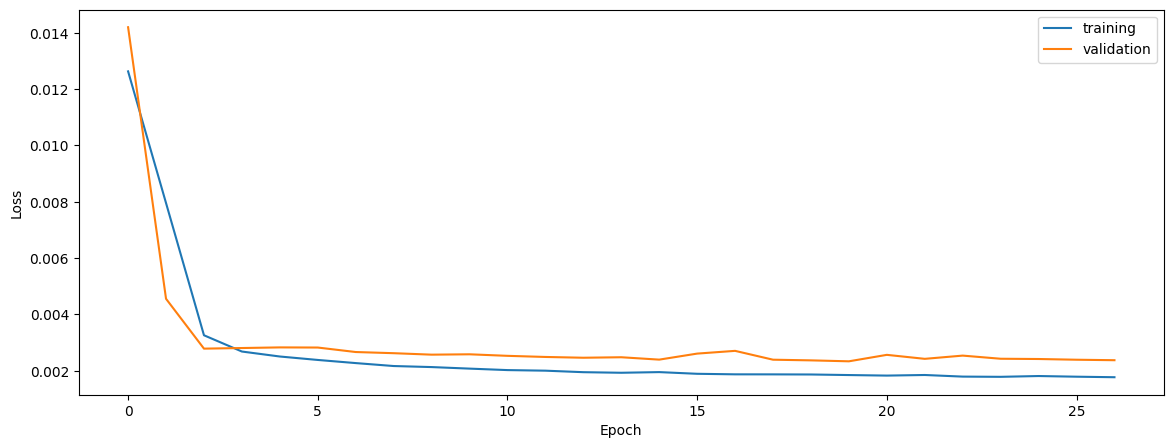

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


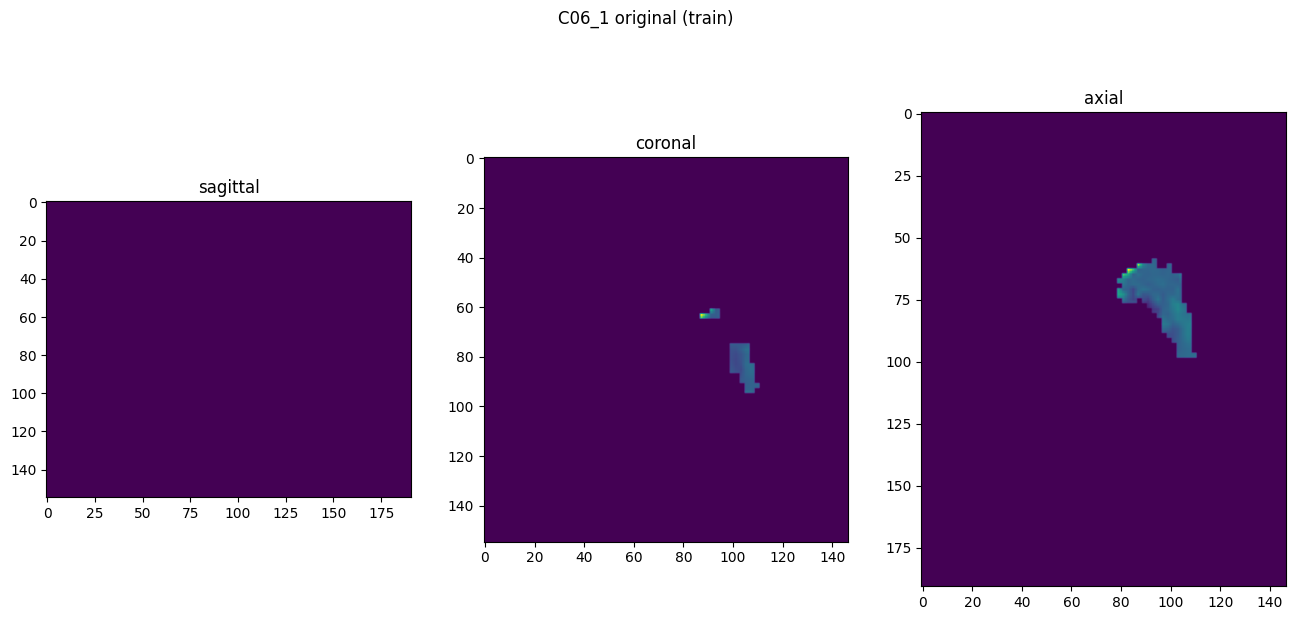

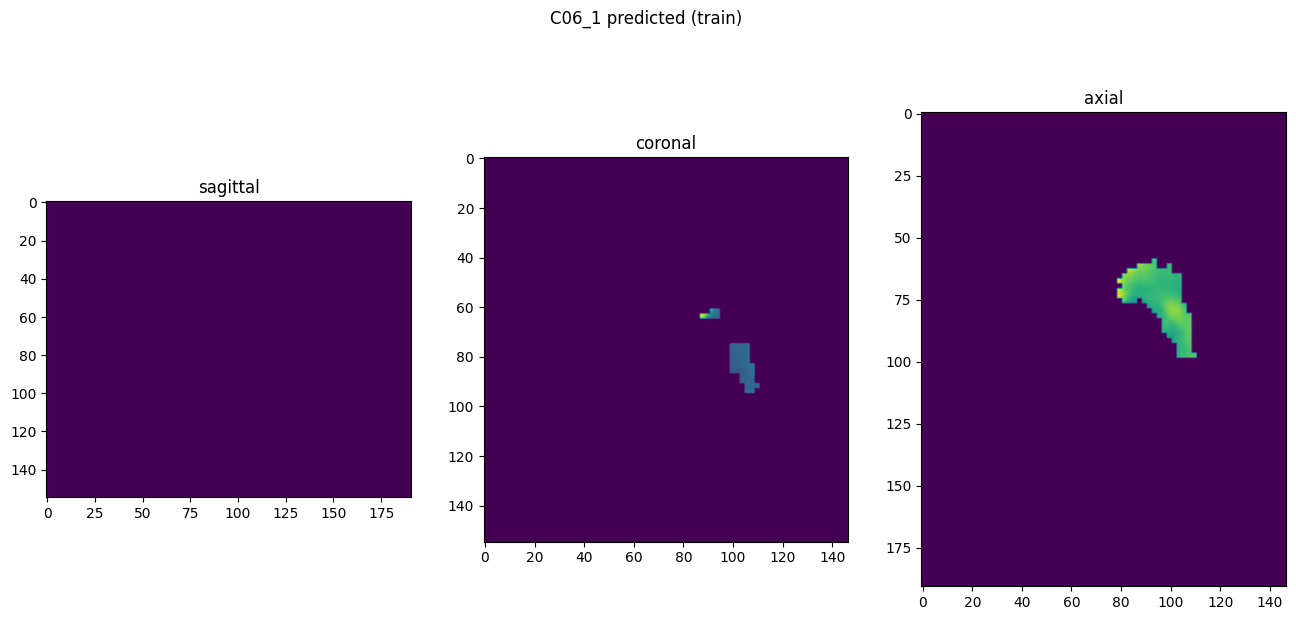

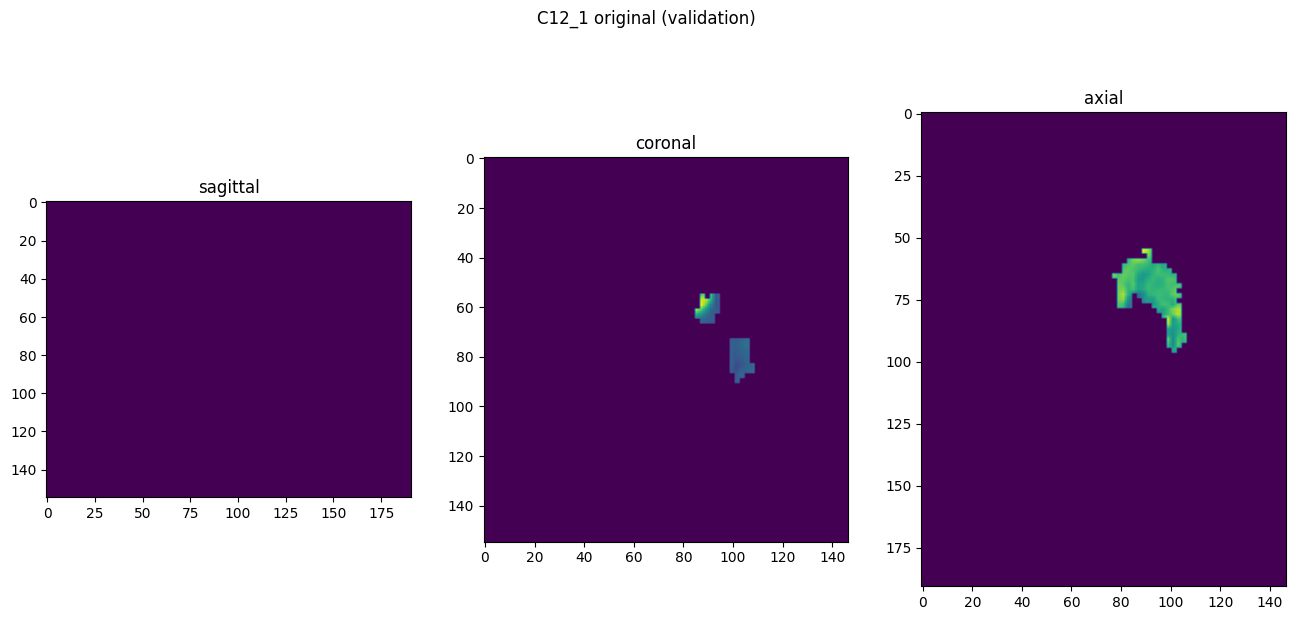

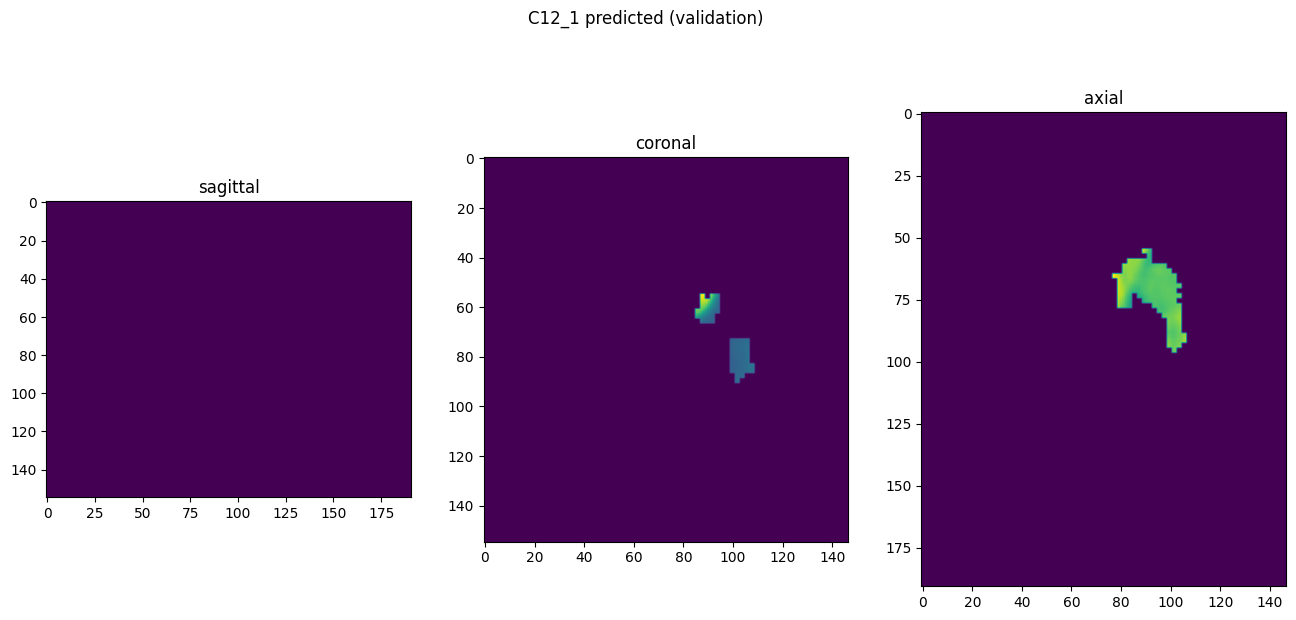

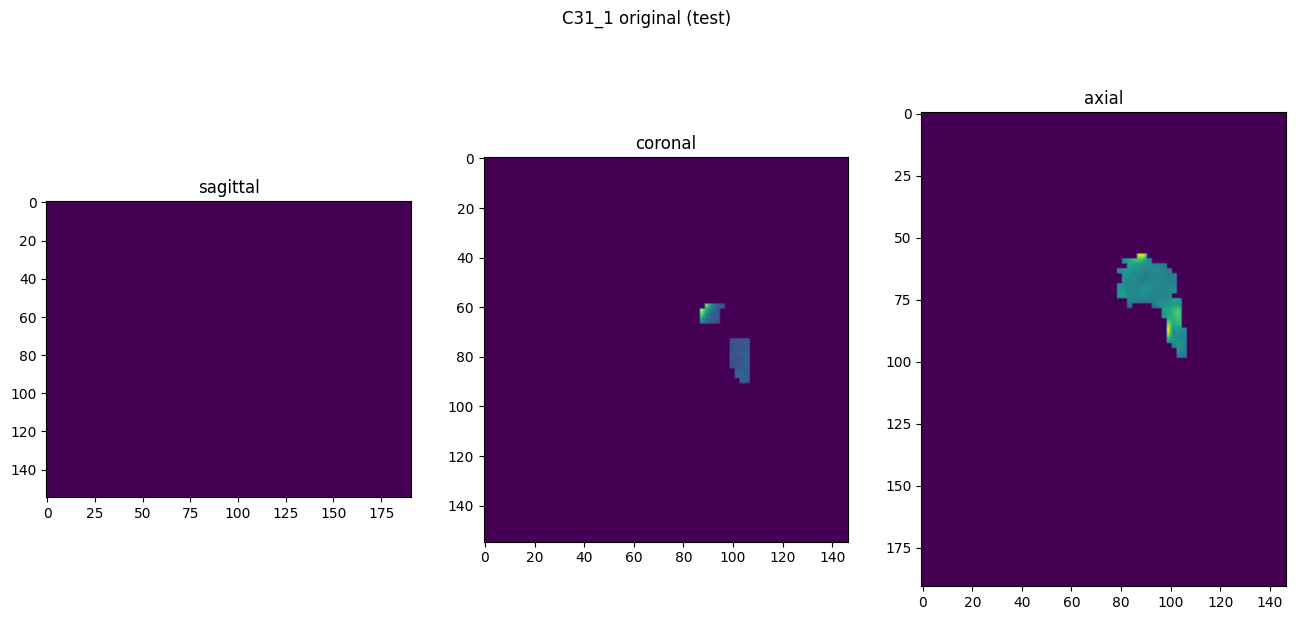

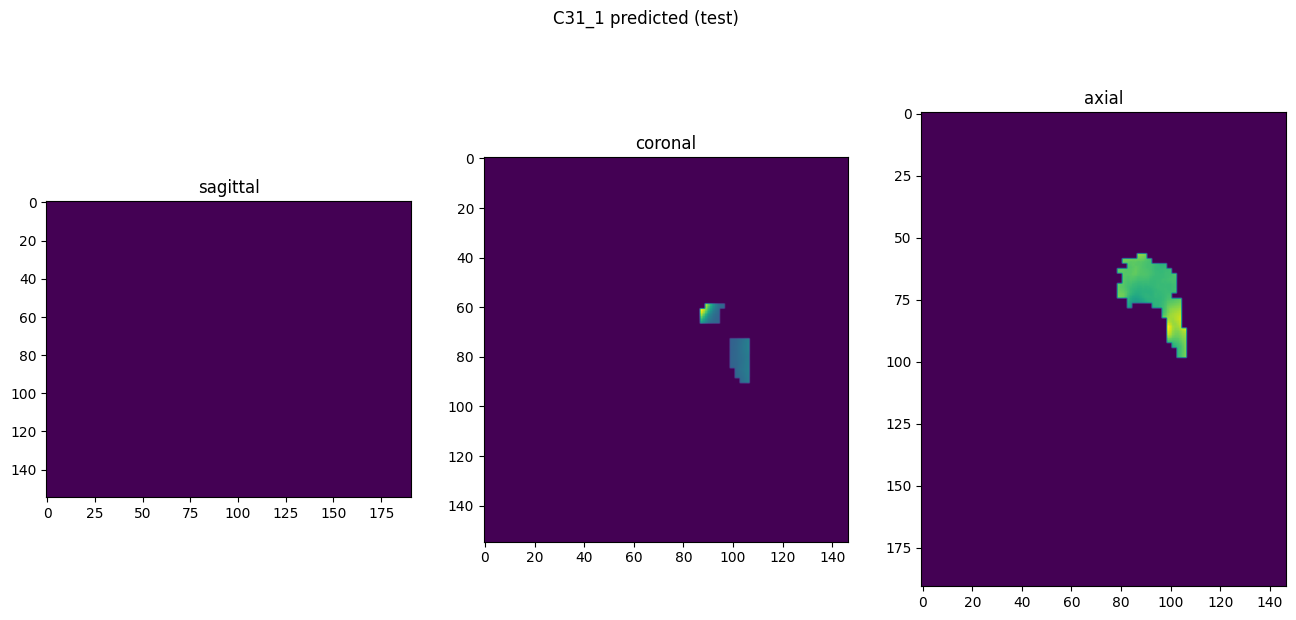

In [10]:
showResults(model, gen, threshold=None, background=False)